In [4]:
import shap
from datasets import load_dataset
from src.utils import MODEL_NAME_TO_DESC_DICT, format_text_pred, prepare_text
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoModelForSequenceClassification, pipeline, AutoTokenizer
import pandas as pd
from datasets import load_dataset, DatasetDict, Dataset
from transformers.pipelines.pt_utils import KeyDataset
from tqdm import tqdm

import lightgbm as lgb

In [3]:
train_df = load_dataset('james-burton/imdb_genre_prediction2', split='train').to_pandas()

Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--imdb_genre_prediction2-a5449428d75bcc31/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [4]:
t = load_dataset('james-burton/imdb_genre_prediction2', split='test[:10]')
t.to_pandas()[['Year','Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)','Metascore', 'Rank']].values

Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--imdb_genre_prediction2-a5449428d75bcc31/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


array([[2.00900000e+03, 9.50000000e+01, 7.70000000e+00, 3.98972000e+05,
        3.23900000e+01, 7.60000000e+01, 5.08000000e+02],
       [2.01600000e+03, 1.08000000e+02, 5.70000000e+00, 2.47610000e+04,
        5.40000000e-01, 2.20000000e+01, 5.38000000e+02],
       [2.01600000e+03, 1.08000000e+02, 6.30000000e+00, 1.06600000e+03,
        8.32676836e+01, 6.40000000e+01, 8.49000000e+02],
       [2.01600000e+03, 1.23000000e+02, 7.10000000e+00, 1.71410000e+04,
        7.70000000e+00, 7.90000000e+01, 5.52000000e+02],
       [2.01500000e+03, 1.13000000e+02, 6.70000000e+00, 4.16420000e+04,
        8.32676836e+01, 7.10000000e+01, 4.80000000e+02],
       [2.01400000e+03, 9.90000000e+01, 8.10000000e+00, 5.30881000e+05,
        5.90700000e+01, 8.80000000e+01, 2.39000000e+02],
       [2.01600000e+03, 1.01000000e+02, 7.90000000e+00, 5.23310000e+04,
        5.20000000e+00, 8.10000000e+01, 4.48000000e+02],
       [2.00800000e+03, 9.30000000e+01, 7.80000000e+00, 5.02961000e+05,
        1.45000000e+02, 5

In [5]:
t1 = t.to_pandas()[['Year','Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)','Metascore', 'Rank']].values
# append t['Description'] to t1
t2 = np.hstack((t1, np.expand_dims(np.array(t['Description']), axis=1)))

In [6]:
t1.shape

(10, 7)

In [7]:
t2[0,-1]

"An offbeat romantic comedy about a woman who doesn't believe true love exists, and the young man who falls for her."

In [8]:
np.array(t['Description']).shape

(10,)

In [9]:
kmeans = shap.kmeans(t1, 1).data
kmeans

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


array([[2.01400e+03, 1.01000e+02, 7.10000e+00, 2.13764e+05, 5.90700e+01,
        6.40000e+01, 5.38000e+02]])

In [10]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# tokenizer(t2[0,-1], return_tensors="pt")

masker = shap.maskers.Text(tokenizer)

In [11]:
masker.shape(t2[0,-1])[1]

28

In [12]:
m00 = np.zeros(masker.shape(t2[0,-1])[1])

In [13]:
m00

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [14]:
t2[0,-1]

"An offbeat romantic comedy about a woman who doesn't believe true love exists, and the young man who falls for her."

In [15]:
masker(m00, t2[0,-1])

(array(['[MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK]'],
       dtype='<U181'),)

In [16]:
def custom_masker(mask,x):
    tab_mask = mask[:7] # 7 is the number of tabular features
    text_mask = mask[7:]
    masker(text_mask, x)
    return masker.shape(x)[-1]

In [17]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
text_masker = shap.maskers.Text(tokenizer)
def custom_masker(mask, x, M_tab):
    tab_mask = mask[:M_tab]
    text_mask = mask[M_tab:]
    masked_tab = x[:M_tab] * tab_mask
    masked_text = text_masker(mask[M_tab:], x[M_tab])
    return np.hstack([masked_tab.astype('O'), masked_text[0]])

reference = [1.6, -0.6, 'hi there']
mask = np.array([1., 1., 1., 0., 1., 1.])

custom_masker(mask, reference, 2)

array([1.6, -0.6, '[MASK]there'], dtype=object)

In [18]:
masker.token_segments(reference[-1])

(['', 'hi ', 'there', ''], [101, 7632, 2045, 102])

In [19]:
m00 = np.zeros(masker.shape('offbeat romantic comedy')[1])
m00

array([0., 0., 0., 0., 0., 0.])

In [20]:
mask = np.array([1, 1, 0, 1])
text_masker(np.array([1, 1, 0, 1]), 'hi there')

(array(['hi [MASK]'], dtype='<U9'),)

In [21]:
tab_cols = ['Year','Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)','Metascore', 'Rank']
np.concatenate([np.zeros(len(tab_cols)), [tokenizer.mask_token ]*masker.shape(t2[0,-1])[1]])

array(['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '[MASK]',
       '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]',
       '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]',
       '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]',
       '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]',
       '[MASK]', '[MASK]', '[MASK]'], dtype='<U32')

In [22]:
masker.shape(t2[0,-1])[1]

28

In [23]:
tokenizer.mask_token

'[MASK]'

In [1]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

sample_text = 'romantic comedy'
print(masker.token_segments(sample_text))
Z=masker.clustering(sample_text)
fig = plt.figure(figsize=(8, 4))
dn = dendrogram(Z)
plt.show()
print(Z)

NameError: name 'masker' is not defined

(['', 'organic ', 'romantic ', 'comedy', ''], [101, 7554, 6298, 4038, 102])


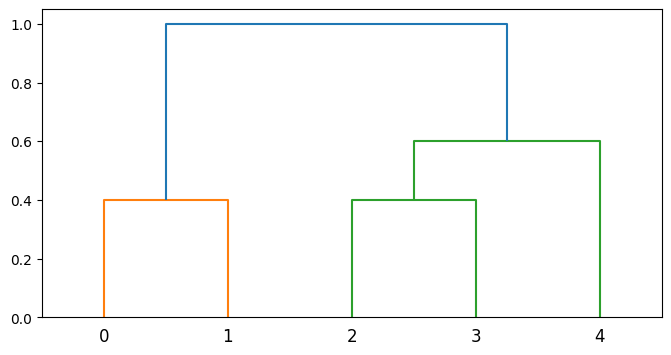

[[0.  1.  0.4 2. ]
 [2.  3.  0.4 2. ]
 [6.  4.  0.6 3. ]
 [5.  7.  1.  5. ]]


In [25]:
sample_text = 'organic romantic comedy'
print(masker.token_segments(sample_text))
Z=masker.clustering(sample_text)
fig = plt.figure(figsize=(8, 4))
dn = dendrogram(Z)
plt.show()
print(Z)

In [26]:
train_df = load_dataset('james-burton/imdb_genre_prediction2', split='train[:10]').to_pandas()

Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--imdb_genre_prediction2-a5449428d75bcc31/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [27]:
import scipy as sp

In [28]:
D = sp.spatial.distance.pdist(train_df[['Rating', 'Runtime (Minutes)', 'Votes']].T, metric="correlation")
C = sp.cluster.hierarchy.complete(D)
# cluster_matrix = shap.partition_tree(X)
C

array([[0.        , 2.        , 0.32772815, 2.        ],
       [1.        , 3.        , 1.03498895, 3.        ]])

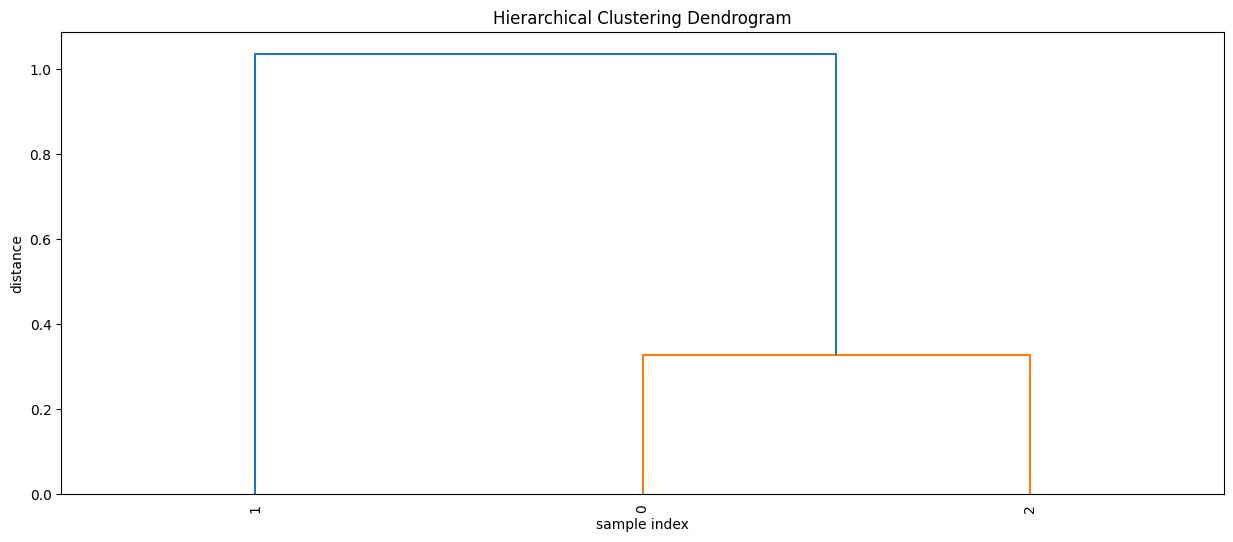

In [29]:
plt.figure(figsize=(15, 6))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    C,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    #labels=['Rating', 'Runtime (Minutes)', 'Votes']
)
plt.show()

In [30]:
np.concatenate([Z, C + [6,6,0,0],[[10.0, 11.0, 1.5, 7.0]]])

array([[ 0.        ,  1.        ,  0.4       ,  2.        ],
       [ 2.        ,  3.        ,  0.4       ,  2.        ],
       [ 6.        ,  4.        ,  0.6       ,  3.        ],
       [ 5.        ,  7.        ,  1.        ,  5.        ],
       [ 6.        ,  8.        ,  0.32772815,  2.        ],
       [ 7.        ,  9.        ,  1.03498895,  3.        ],
       [10.        , 11.        ,  1.5       ,  7.        ]])

In [31]:
C

array([[0.        , 2.        , 0.32772815, 2.        ],
       [1.        , 3.        , 1.03498895, 3.        ]])

In [32]:
n_tab_leaves = 3
text_groups = 4
n_text_leaves = 5
np.where(C[:,:2]>=n_tab_leaves,C[:,:2]+n_text_leaves+ text_groups,C[:,:2]+n_text_leaves)

array([[ 5.,  7.],
       [ 6., 12.]])

In [33]:
C[:,:2]>=n_tab_leaves

array([[False, False],
       [False,  True]])

In [34]:
Z_leaves = len(np.hstack(Z[:,:2]))
C_leaves = len(np.hstack(C[:,:2]))
total_leaves = float(Z_leaves + C_leaves)

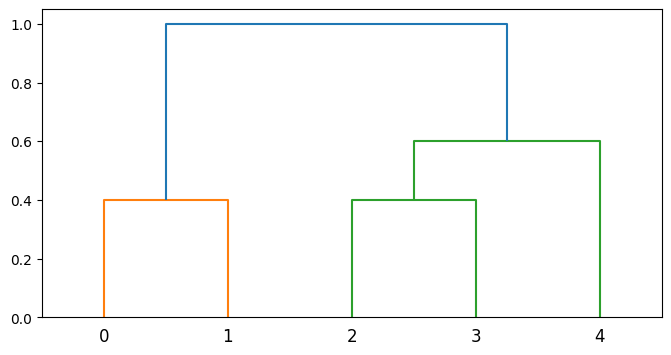

In [35]:
Z
fig = plt.figure(figsize=(8, 4))
# dn = dendrogram(np.concatenate([Z, C + [6,6,0,6],[[10.0, 11.0, 1.5, 7.0]]]), labels=['s', 'romantic ', 'comedy', 's','Rating', 'Run', 'Votes'])
dn = dendrogram(Z) #, labels=['Rating', 'Run', 'Votes','s', 'romantic ', 'comedy', 's'])
plt.show()

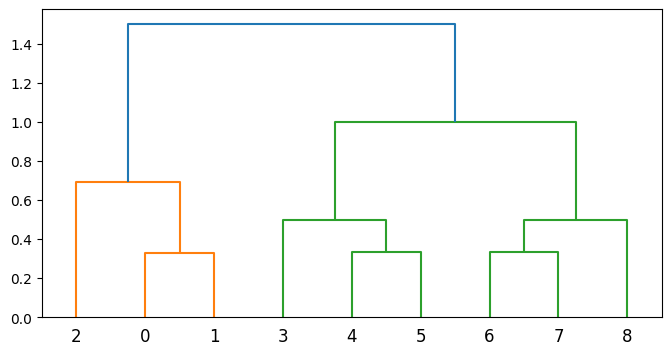

In [37]:
# Z_join = np.array([
#     [ 1.        ,  2.        ,  0.33333333,  2.        ],
#        [ 3.        ,  4.        ,  0.33333333,  2.        ],
#        [ 0.        ,  9.        ,  0.5       ,  3.        ],
#        [10.        ,  5.        ,  0.5       ,  3.        ],
#        [11.        , 12.        ,  1.        ,  6.        ],
#        [ 6.        ,  7.        ,  0.32772815,  2.        ],
#        [ 8.        , 14.        ,  0.69322193,  3.        ],
#        [13.        , 15.        ,  1.5       ,  9.        ]])
Z_join = np.array([[ 0.        ,  1.        ,  0.32772815,  2.        ],
       [ 2.        ,  9.        ,  0.69322193,  3.        ],
       [ 4.        ,  5.        ,  0.33333333,  2.        ],
       [ 6.        ,  7.        ,  0.33333333,  2.        ],
       [ 3.        , 11.        ,  0.5       ,  3.        ],
       [12.        ,  8.        ,  0.5       ,  3.        ],
       [13.        , 14.        ,  1.        ,  6.        ],
       [10.        , 15.        ,  1.5       ,  9.        ]])

Z_join = np.array([[ 0.        ,  1.        ,  0.32772815,  2.        ],
       [ 2.        ,  9.        ,  0.69322193,  3.        ],
       [ 4.        ,  5.        ,  0.33333333,  2.        ],
       [ 6.        ,  7.        ,  0.33333333,  2.        ],
       [ 3.        , 11.        ,  0.5       ,  3.        ],
       [12.        ,  8.        ,  0.5       ,  3.        ],
       [13.        , 14.        ,  1.        ,  6.        ],
       [10.        , 15.        ,  1.5       ,  9.        ]])
fig = plt.figure(figsize=(8, 4))
# dn = dendrogram(np.concatenate([Z, C + [6,6,0,6],[[10.0, 11.0, 1.5, 7.0]]]), labels=['s', 'romantic ', 'comedy', 's','Rating', 'Run', 'Votes'])
dn = dendrogram(Z_join) #, labels=['Rating', 'Run', 'Votes','s', 'romantic ', 'comedy', 's'])
plt.show()

In [224]:
y = Z.copy()
y #(Z[:,:2]>=6)*3

array([[0. , 1. , 0.4, 2. ],
       [2. , 3. , 0.4, 2. ],
       [6. , 4. , 0.6, 3. ],
       [5. , 7. , 1. , 5. ]])

In [225]:
y[:,:2] += (Z[:,:2]>=6)*3

In [245]:
Z

array([[ 5. ,  6. ,  0.4,  2. ],
       [ 7. , 10. ,  0.4,  2. ],
       [13. , 11. ,  0.6,  3. ],
       [12. , 14. ,  1. ,  5. ]])

In [212]:
C

array([[0.        , 2.        , 0.49212894, 2.        ],
       [1.        , 3.        , 0.62301468, 3.        ]])

In [239]:
np.concatenate([Z,C])

array([[0.        , 1.        , 0.4       , 2.        ],
       [2.        , 3.        , 0.4       , 2.        ],
       [6.        , 4.        , 0.6       , 3.        ],
       [5.        , 7.        , 1.        , 5.        ],
       [0.        , 2.        , 0.49212894, 2.        ],
       [1.        , 3.        , 0.62301468, 3.        ]])

In [214]:
len(np.hstack(Z[:,:2]))

8

In [270]:
def combine_dendrograms(tab_pt, text_pt, n_tab_leaves, n_text_leaves):
    '''
    Dendrograms creation works by having each one of the base leaves as a number, then
    labelling each one of the new created nodes a number following the last leaf number.
    
    eg for array([[0. , 1. , 0.4, 2. ],
       [2. , 3. , 0.4, 2. ],
       [6. , 4. , 0.6, 3. ],
       [5. , 7. , 1. , 5. ]])
       
    In this case we know previously leaves are [0,1,2,3,4] (I don't think there is an easy
    way to calculate this from the dendrogram itself). Therefore the pairing of (0,1) from
    row 0 is labelled as 5, (2,3) from row 1 is labelled as 6, (6,4) from row 2 is labelled as 7
    and (5,7) from row 3 is labelled as 8.
    '''
    n_text_groups = len(text_pt)
    n_tab_groups = len(tab_pt)
    
    # References to non-leaf nodes need to be shifted by the number of new leaves
    Z_join = np.zeros([n_tab_groups+n_text_groups+1,4])
    Z_join[:n_text_groups,:2] = np.where(text_pt[:,:2]>=n_text_leaves, text_pt[:,:2]+ n_tab_leaves, text_pt[:,:2])
    Z_join[n_text_groups:-1,:2] = np.where(tab_pt[:,:2]>=n_tab_leaves,
                                          tab_pt[:,:2]+n_text_leaves+ n_text_groups,
                                          tab_pt[:,:2]+n_text_leaves)
    # 3rd and 4th columns are left unchanged
    Z_join[:n_text_groups,2:] = text_pt[:,2:]
    Z_join[n_text_groups:-1,2:] = tab_pt[:,2:]
    
    # Z_text[:,:2] += (Z_text[:,:2]>=n_text_leaves)*n_tab_leaves
    # Z_tab[:,:2] = np.where(Z_tab[:,:2]>=n_tab_leaves,Z_tab[:,:2]+n_text_leaves+ n_text_groups,
    #                        Z_tab[:,:2]+n_text_leaves)
    
    # Create top join, joining the text and tab dendrograms together
    top_text_node = n_text_leaves + n_tab_leaves + n_text_groups + -1
    top_tab_node = top_text_node + n_tab_groups
    # Set similarity of top node to 1.5
    Z_join[-1,:] = np.array([top_text_node, top_tab_node, 1.5, n_tab_leaves + n_text_leaves])
    
    return Z_join
 
Z_combined = combine_dendrograms(C, Z, 3, 5)
Z_combined
    

array([[ 0.        ,  1.        ,  0.4       ,  2.        ],
       [ 2.        ,  3.        ,  0.4       ,  2.        ],
       [ 9.        ,  4.        ,  0.6       ,  3.        ],
       [ 8.        , 10.        ,  1.        ,  5.        ],
       [ 5.        ,  7.        ,  0.49212894,  2.        ],
       [ 6.        , 12.        ,  0.62301468,  3.        ],
       [11.        , 13.        ,  1.5       ,  8.        ]])

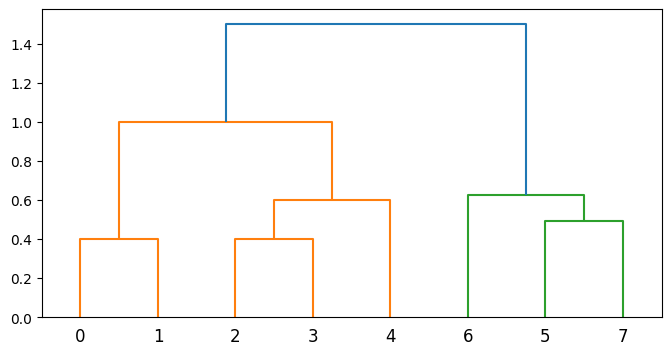

In [271]:
C
fig = plt.figure(figsize=(8, 4))
# dn = dendrogram(np.concatenate([Z, C + [6,6,0,6],[[10.0, 11.0, 1.5, 7.0]]]), labels=['s', 'romantic ', 'comedy', 's','Rating', 'Run', 'Votes'])
dn = dendrogram(Z_combined) #, labels=['Rating', 'Run', 'Votes','s', 'romantic ', 'comedy', 's'])
plt.show()

In [197]:
Z_comb2


array([[ 0.        ,  1.        ,  0.4       ,  2.        ],
       [ 2.        ,  3.        ,  0.4       ,  2.        ],
       [ 6.        ,  4.        ,  0.6       ,  3.        ],
       [ 5.        ,  7.        ,  1.        ,  5.        ],
       [ 8.        , 10.        ,  0.49212894,  2.        ],
       [ 9.        , 11.        ,  0.62301468,  3.        ],
       [12.        , 13.        ,  1.5       , 12.        ]])

In [186]:
np.sort(Z_comb2, axis=0)

array([[ 0.        ,  1.        ,  0.4       ,  2.        ],
       [ 2.        ,  3.        ,  0.4       ,  2.        ],
       [ 5.        ,  4.        ,  0.49212894,  2.        ],
       [ 6.        ,  7.        ,  0.6       ,  3.        ],
       [ 8.        , 10.        ,  0.62301468,  3.        ],
       [ 9.        , 11.        ,  1.        ,  5.        ],
       [12.        , 13.        ,  1.5       , 12.        ]])

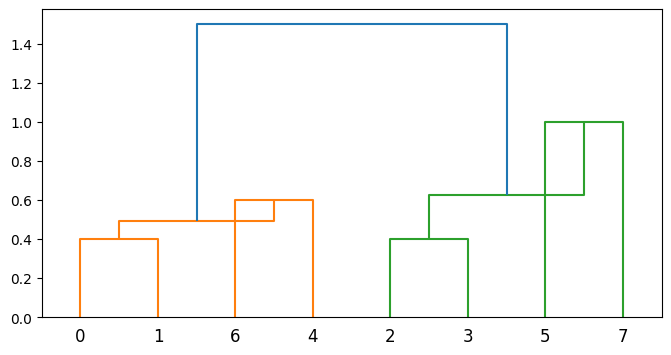

In [200]:
Z_comb2 = np.concatenate([Z, C + [Z_leaves,Z_leaves,0,0],[[total_leaves, total_leaves+1, 1.5, total_leaves]]])
fig = plt.figure(figsize=(8, 4))
# dn = dendrogram(np.concatenate([Z, C + [6,6,0,6],[[10.0, 11.0, 1.5, 7.0]]]), labels=['s', 'romantic ', 'comedy', 's','Rating', 'Run', 'Votes'])
dn = dendrogram(Z_comb2) #, labels=['Rating', 'Run', 'Votes','s', 'romantic ', 'comedy', 's'])
plt.show()

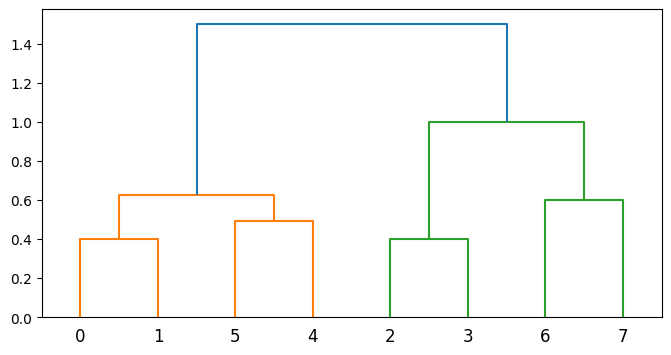

In [201]:
fig = plt.figure(figsize=(8, 4))
# dn = dendrogram(np.concatenate([Z, C + [6,6,0,6],[[10.0, 11.0, 1.5, 7.0]]]), labels=['s', 'romantic ', 'comedy', 's','Rating', 'Run', 'Votes'])
dn = dendrogram(np.sort(Z_comb2, axis=0)) #, labels=['Rating', 'Run', 'Votes','s', 'romantic ', 'comedy', 's'])
plt.show()

In [142]:
len(np.hstack(Z[:,:2]))

4

In [180]:
Z

array([[0. , 1. , 0.4, 2. ],
       [2. , 3. , 0.4, 2. ],
       [6. , 4. , 0.6, 3. ],
       [5. , 7. , 1. , 5. ]])

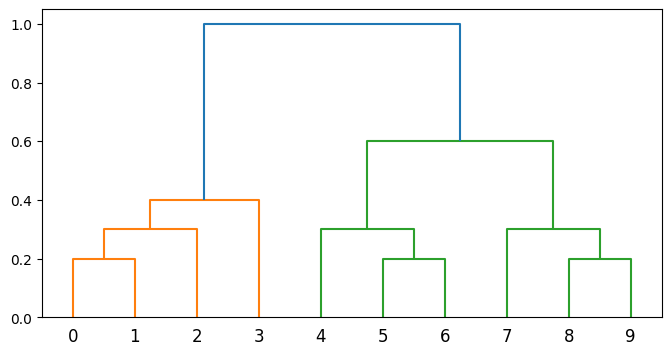

In [6]:
Z3 = np.array([[ 5. ,  6. ,  0.2,  2. ],
       [ 0. ,  1. ,  0.2,  2. ],
       [ 8. ,  9. ,  0.2,  2. ],
       [11. ,  2. ,  0.3,  3. ],
       [ 4. , 10. ,  0.3,  3. ],
       [ 7. , 12. ,  0.3,  3. ],
       [14. , 15. ,  0.6,  6. ],
       [13. ,  3. ,  0.4,  4. ],
       [17. , 16. ,  1. , 10. ]])

fig = plt.figure(figsize=(8, 4))
# dn = dendrogram(np.concatenate([Z, C + [6,6,0,6],[[10.0, 11.0, 1.5, 7.0]]]), labels=['s', 'romantic ', 'comedy', 's','Rating', 'Run', 'Votes'])
dn = dendrogram(Z3) #, labels=['Rating', 'Run', 'Votes','s', 'romantic ', 'comedy', 's'])
plt.show()

# sp.cluster.hierarchy.dendrogram(
#     Z,
#     #leaf_rotation=90.,  # rotates the x axis labels
#     #leaf_font_size=10.,  # font size for the x axis labels
#     #labels=['Rating', 'Runtime (Minutes)', 'Votes']
# )



In [76]:
Z

array([[0. , 1. , 0.5, 2. ],
       [2. , 3. , 0.5, 2. ],
       [4. , 5. , 1. , 4. ]])

In [64]:
Z_combined

array([[ 3.        ,  4.        ,  1.73698908,  2.        ],
       [ 0.        ,  1.        ,  2.82842712,  2.        ],
       [ 2.        ,  6.        ,  6.02079729,  3.        ],
       [ 5.        ,  7.        , 11.67241532,  5.        ]])

In [65]:
cluster_matrix

array([[1.        , 2.        , 0.49212894, 2.        ],
       [0.        , 3.        , 0.62301468, 3.        ]])

In [ ]:
masker.shape(sample_text)

(1, 11)

In [ ]:
# text_model = torch.compile(text_model)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
text_pipeline = pipeline('text-classification', model="james-burton/imdb_genre_9", tokenizer=tokenizer, device="cuda:0")


In [ ]:
test_df = load_dataset('james-burton/imdb_genre_prediction2', split='test')
tab_cols = ['Year','Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)','Metascore', 'Rank']
text_col = ['Description']

test_df_text = prepare_text(test_df, 'text_col_only')
test_df_tab = test_df.to_pandas()[tab_cols]

train_df = load_dataset('james-burton/imdb_genre_prediction2', split='train').to_pandas()
train_df_tab = train_df[tab_cols]
y_train = train_df['Genre_is_Drama']

tab_model = lgb.LGBMClassifier(random_state=42)
# tab_model = XGBClassifier(random_state=42)
tab_model.fit(train_df_tab,y_train)

def tab_pred_fn(examples):
    preds = tab_model.predict_proba(examples)
    return preds

Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--imdb_genre_prediction2-a5449428d75bcc31/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/home/james/.cache/huggingface/datasets/james-burton___parquet/james-burton--imdb_genre_prediction2-a5449428d75bcc31/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [ ]:
class Model():
    def __init__(self, text_to_pred_dict=None):
        self.text_to_pred_dict = text_to_pred_dict
        self.text_pred_len = 0
        
    def predict_both(self, examples, text_weight=0.5, load_from_cache=True):
        tab_examples = examples[:,:-1]
        tab_preds = tab_model.predict_proba(tab_examples)
        text_examples = examples[:,-1]
        
        desc_dict = {}
        for i, desc in tqdm(enumerate(text_examples)):
            if desc not in desc_dict:
                desc_dict[desc] = [i]
            else:
                desc_dict[desc].append(i)
        
        if load_from_cache:
            text_preds = np.array([self.text_to_pred_dict[desc] for desc in desc_dict.keys()])    
            
        else:
            text_preds = text_pipeline(list(desc_dict.keys()))
            text_preds = np.array([format_text_pred(pred) for pred in text_preds])
                            
        
        expanded_text_preds = np.zeros((len(text_examples), 2))
        for i, (desc, idxs) in enumerate(desc_dict.items()):
            expanded_text_preds[idxs] = text_preds[i]
        
        # Combine the predictions, multiplying the text and predictions by 0.5
        preds = text_weight * expanded_text_preds + (1-text_weight) * tab_preds
        return preds

In [ ]:
from custom_kernel_explainer import CustomKernel
test_model = Model()

kernel_explain = CustomKernel(lambda x: test_model.predict_both(x,text_weight=0.5), shap.kmeans(train_df[tab_cols], 10))

kernel_shap_values = kernel_explain.shap_values(test_df[tab_cols + text_col][:2], seed=42) #, nsamples=100)
# shap.summary_plot(kernel_shap_values, X_test, plot_type="bar")

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


UnboundLocalError: local variable 'model_null' referenced before assignment

In [ ]:
shap.kmeans(train_df[tab_cols], 10).weights

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


array([0.20588235, 0.06764706, 0.02205882, 0.11323529, 0.29705882,
       0.00441176, 0.04117647, 0.07647059, 0.13235294, 0.03970588])

## Custom masker

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


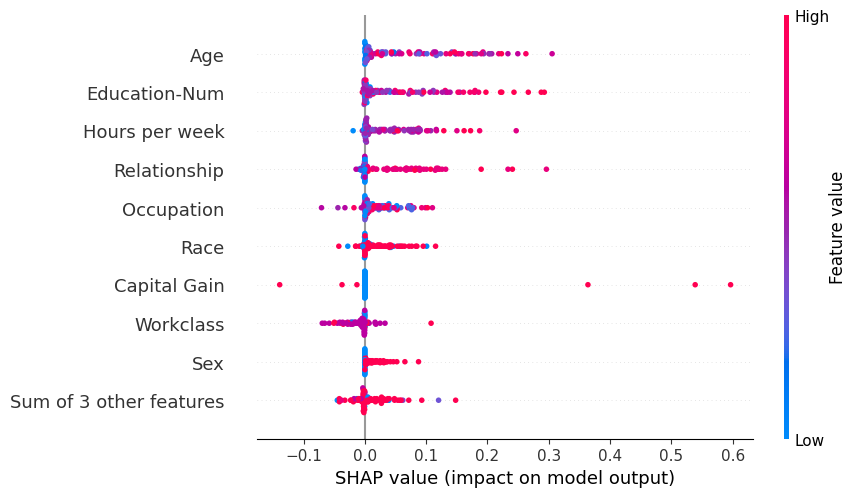

In [ ]:
import xgboost
import shap
import numpy as np
from src.joint_masker import JointMasker

# train XGBoost model
X,y = shap.datasets.adult()
model = xgboost.XGBClassifier().fit(X.values, y)

# A masking function takes a binary mask vector as the first argument and
# the model arguments for a single sample after that
# It returns a masked version of the input x, where you can return multiple
# rows to average over a distribution of masking types
def custom_masker(mask, x):
    return (x * mask).reshape(1,len(x)) # in this simple example we just zero out the features we are masking

# compute SHAP values
explainer = shap.Explainer(model.predict_proba, custom_masker)
shap_values = explainer(X[:100])

# plot the SHAP values for the positive class
shap.plots.beeswarm(shap_values[...,1])

In [ ]:
masker = shap.maskers._text.Text()